In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-095a6003-6269-486e-8bf7-22f7856e2a33',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': '5rd4JjbLDtIKnWhmwbTnQGOA7c5tDfii-FOwpOKtsX-V'
}

configuration_name = 'os_2746aaba51d24cd3a479f8d2da307b1d_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200706075609-0000
KERNEL_ID = fe03c772-1cac-43d7-8853-13ebc946fca8


# Sparkify Project Workspace
This workspace uses a subset of (256MB) of the full available dataset (12GB). 


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import col
from pyspark.sql.functions import concat
from pyspark.sql.functions import desc
from pyspark.sql.functions import explode
from pyspark.sql.functions import lit
from pyspark.sql.functions import min
from pyspark.sql.functions import max
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import isnan
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

import re

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-42ldwg6hxv8yav'))
df_1.take(2)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98')]

In [4]:
df_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is medium-sparkify-event-data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df_1.describe().where("summary = 'count'").show()

+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|summary|artist|  auth|firstName|gender|itemInSession|lastName|length| level|location|method|  page|registration|sessionId|  song|status|    ts|userAgent|userId|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|  count|432877|543705|   528005|528005|       543705|  528005|432877|543705|  528005|543705|543705|      528005|   543705|432877|543705|543705|   528005|543705|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+



we can see that not all rows have equal number of count. This indicates that there are null values in each column. We can drop those null values especially in userId and page coulmn to get clean dataset for analysis

In [6]:
df = df_1.filter(df_1.page.isNotNull()).filter(df_1.userId.isNotNull())

In [7]:
df.describe().where("Summary = 'count'").show()

+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|summary|artist|  auth|firstName|gender|itemInSession|lastName|length| level|location|method|  page|registration|sessionId|  song|status|    ts|userAgent|userId|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|  count|432877|543705|   528005|528005|       543705|  528005|432877|543705|  528005|543705|543705|      528005|   543705|432877|543705|543705|   528005|543705|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+



 #### The dataset has only no null values in userIds, ts, status, page, level, itemInsession, auth.  But there are other field like artist, lenght, song are found.  Let us see if these are valid cases be have null values 

In [8]:
! pip install sparksql-magic

    100% |████████████████████████████████| 204.7MB 118kB/s eta 0:00:01███████▌ | 195.3MB 45.8MB/s eta 0:00:01
    100% |████████████████████████████████| 788kB 5.1MB/s eta 0:00:01
    100% |████████████████████████████████| 204kB 5.9MB/s eta 0:00:01
    100% |████████████████████████████████| 921kB 4.9MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 5.3MB/s eta 0:00:01
    100% |████████████████████████████████| 358kB 5.5MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 4.4MB/s eta 0:00:01
    100% |████████████████████████████████| 798kB 5.7MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 4.0MB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 6.1MB/s ta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
pytest-astropy 0.8.0 requires pytes

In [9]:
%reload_ext sparksql_magic

In [10]:
df.createOrReplaceTempView("log_table")

In [11]:
spark.sql("select distinct(page) from log_table \
           where song is not null \
           and artist is not null \
           and length is not null \
        ").show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



It is understandable that field `artist, lenght, song` are log  only for `NextSong` page where it makes sense. Let us find out why the fields like `firstName, gender, lastname, registration,  userAgent` are not logged 

In [12]:
spark.sql("select distinct(auth) from log_table \
            where song is null ").show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [13]:
spark.sql("select distinct(auth) from log_table \
           where firstName is not null \
           and gender is not null \
           and lastName is not null \
           and registration is not null \
           and userAgent is not null \
        ").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



We could see the `firstName, gender, lastname, registration,  userAgent` are not logged for users we were never registered. that is `Guest` users. This names sense as we will never have such details with out registering for the service .  Now the data is good we start the Exploratory analysis

# Exploratory Data Analysis

### Define Churn
Churn can be defined as user leaving the service.  This is indicated by presence of `Cancellation Confirmation` page.  `Downgrade` event can also be early indicator of churn

After the EDA analysis a column `Churn` to use as the label for the model indicating user using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. 

### Explore Data
Exploratory data analysis is done to observe the behavior for users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

As this is timeseriese data, Let us find the what is time period of data available 

In [14]:
spark.sql("select from_unixtime(min(ts)/1000) as start_date, \
                  from_unixtime(max(ts)/1000) as end_date \
          from log_table").show()

+-------------------+-------------------+
|         start_date|           end_date|
+-------------------+-------------------+
|2018-10-01 00:00:11|2018-12-01 00:01:06|
+-------------------+-------------------+



The log seems to have 2 months of data strting from `2018-10-01` to `2018-11-30` 

In [15]:
spark.sql('''
select count(distinct( userId))
  from log_table
''').show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   449|
+----------------------+



There are `499` distinct registered users - they can register as `paid` or `free` level

In [16]:
%%sparksql -l 100
select 
       (select count(distinct(userId)) 
          from log_table
         where page  = 'Register'
           and level = 'free'         
       ) as Free_registered_users
      ,(select count(distinct(userId)) 
          from log_table
         where page  = 'Register'
           and level = 'paid'
       ) as Paid_registered_users
      ,(select count(distinct(userId)) 
          from log_table
         where page  = 'Upgrade'
           and level = 'free'       
       ) as Upgraded_users 
      ,(select count(distinct(userId)) 
          from log_table
         where page  = 'Downgrade'
           and level = 'paid'
       ) as Downgrade_users
      ,(select count(distinct(userId)) 
          from log_table
         where page  = 'Cancel'
           and level = 'free'         
       ) as Free_cancelled_users 
      ,(select count(distinct(userId)) 
          from log_table
         where page  = 'Cancel'
           and level = 'paid'         
       ) as paid_cancelled_users      
  from log_table
 limit 1

Free_registered_users,Paid_registered_users,Upgraded_users,Downgrade_users,Free_cancelled_users,paid_cancelled_users
1,0,315,301,32,67


The above counts of user indicate how users actions over the timeperiod of the dataset. There is overlap between these buclekts of user.s So total user here will be more than the total distinct user we found in the dataset.
 Let us find the distribution of cancelled users by listening time and time since registered and frequency of Advert Rolls.  I believe these factors could gauge the interest of the user to stick on to the service as paid user 

First let us look at the per user listening time per week for cancelled and registered user by paid and free user levels. This gives us a view of how much time user spends on listening to song each week

In [17]:
df_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,sum(a.length) as listen_time_cancelled_user
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'NextSong'
   and b.page = 'Cancel'
 group by week
         ,a.level
 order by week
         ,a.level
''').toPandas()

In [18]:
df_r = spark.sql('''
-- Registered users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,sum(a.length) as listen_time_Registered_user
      ,count(distinct a.userId) as user_R
  from log_table a
 where a.page = 'NextSong'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
      ,a.level
 order by week
      ,a.level
''').toPandas()

In [19]:
# Caputure the result of both the queries as pandas dataframe
df_listen = pd.merge(df_c, df_r, on=['week', 'level'])

In [20]:
df_listen.columns

Index(['week', 'level', 'listen_time_cancelled_user', 'user_C',
       'listen_time_Registered_user', 'user_R'],
      dtype='object')

In [21]:
df_listen['prop_time_can_user'] = df_listen['listen_time_cancelled_user'] / df_listen['user_C'] 
df_listen['prop_time_reg_user'] = df_listen['listen_time_Registered_user'] / df_listen['user_R'] 

In [22]:
df_listen

,week,level,listen_time_cancelled_user,user_C,listen_time_Registered_user,user_R,prop_time_can_user,prop_time_reg_user
0,40,free,1.695916e+06,66,2.892484e+06,191,25695.693486,15143.893707
1,40,paid,1.767395e+06,38,4.404921e+06,90,46510.406113,48943.571144
2,41,free,1.107681e+06,51,2.625707e+06,155,21719.229741,16940.045527
3,41,paid,2.042826e+06,35,6.593733e+06,118,58366.460425,55879.089410
4,42,free,8.719946e+05,40,2.190141e+06,132,21799.865153,16591.974162
5,42,paid,1.966962e+06,31,7.110878e+06,136,63450.390975,52285.865576
6,43,free,4.655796e+05,24,1.560925e+06,121,19399.149028,12900.208299
7,43,paid,2.885270e+06,39,7.639620e+06,133,73981.281241,57440.754010
8,44,free,2.884811e+05,14,1.701061e+06,122,20605.794364,13943.119010
9,44,paid,2.855998e+06,40,8.849175e+06,147,71399.940848,60198.471073


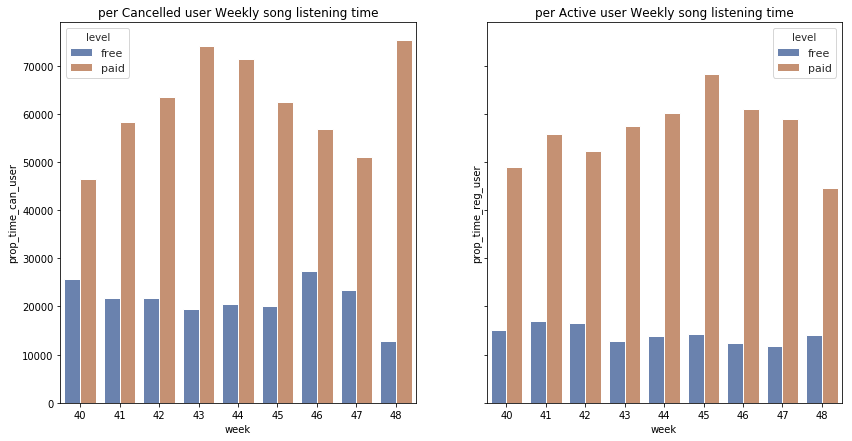

In [23]:
 # Plot the df_listen figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_listen, x='week', y='prop_time_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("per Cancelled user Weekly song listening time")

ax2 = sbn.barplot(data=df_listen, x='week', y='prop_time_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("per Active user Weekly song listening time")

plt.show();

The paid user seems to spend more time as expected. But it is surprising to see per cancelled users send more time listening to song in a week than per registered user especially in the last week. Let us now considered number of sessions per week for cancelled and registered user. 

In [24]:
df_c_s = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(distinct a.sessionId) as Can_user_sessions
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'NextSong'
   and b.page = 'Cancel'
 group by week
         ,a.level
 order by week
         ,a.level
''').toPandas()

In [25]:
df_r_s = spark.sql('''
-- Registered users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(distinct a.sessionId) as Reg_user_sessions
      ,count(distinct a.userId) as user_R
  from log_table a
 where a.page = 'NextSong'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
      ,a.level
 order by week
      ,a.level
''').toPandas()


In [26]:
# Caputure the result of both the queries as pandas dataframe
df_session = pd.merge(df_c_s, df_r_s, on=['week', 'level'])

In [27]:
df_session.columns

Index(['week', 'level', 'Can_user_sessions', 'user_C', 'Reg_user_sessions',
       'user_R'],
      dtype='object')

In [28]:
df_session['prop_time_can_user'] = df_session['Can_user_sessions'] / df_session['user_C'] 
df_session['prop_time_reg_user'] = df_session['Reg_user_sessions'] / df_session['user_R'] 

In [29]:
df_session

,week,level,Can_user_sessions,user_C,Reg_user_sessions,user_R,prop_time_can_user,prop_time_reg_user
0,40,free,185,66,342,191,2.803030,1.790576
1,40,paid,86,38,188,90,2.263158,2.088889
2,41,free,136,51,306,155,2.666667,1.974194
3,41,paid,72,35,287,118,2.057143,2.432203
4,42,free,109,40,272,132,2.725000,2.060606
5,42,paid,83,31,306,136,2.677419,2.250000
6,43,free,58,24,228,121,2.416667,1.884298
7,43,paid,113,39,326,133,2.897436,2.451128
8,44,free,35,14,224,122,2.500000,1.836066
9,44,paid,110,40,380,147,2.750000,2.585034


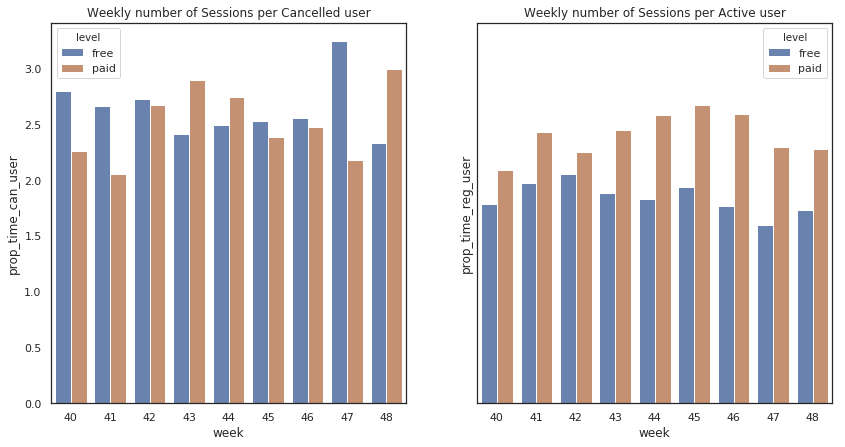

In [30]:
# Plot the df_listen figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_session, x='week', y='prop_time_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly number of Sessions per Cancelled user")

ax2 = sbn.barplot(data=df_session, x='week', y='prop_time_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly number of Sessions per Active user")

plt.show();

The paid and registered user seems to have more number of session per week as compared to registered and free user as the graph 2. But tread is not very eveident with cancelled users.

Let us now see number of `items per week` which indicates the navigation the users

In [31]:
df_items_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_item
      ,count(distinct a.userId) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and b.page = 'Cancel'
 group by week
        ,a.level
 order by week
        ,a.level
''').toPandas()

In [32]:
df_items_c.head()

,week,level,Can_user_item,user_C
0,40,free,9218,67
1,40,paid,8568,39
2,41,free,5935,51
3,41,paid,9679,35
4,42,free,4625,40


In [33]:
df_items_r = spark.sql('''
-- active users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Reg_user_items
      ,count(distinct a.userId) as user_R
  from log_table a \
 where a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
         ,a.level
 order by week
         ,a.level
''').toPandas()

In [34]:
df_items_r.head()

,week,level,Reg_user_items,user_R
0,40,free,16332,194
1,40,paid,22032,93
2,41,free,14736,158
3,41,paid,32730,121
4,42,free,12188,136


In [35]:
# Caputure the result of both the queries as pandas dataframe
df_items = pd.merge(df_c_s, df_r_s, on=['week', 'level'])
df_items['prop_items_can_user'] = df_items['Can_user_sessions'] / df_items['user_C'] 
df_items['prop_items_reg_user'] = df_items['Reg_user_sessions'] / df_items['user_R'] 
df_items.head()

,week,level,Can_user_sessions,user_C,Reg_user_sessions,user_R,prop_items_can_user,prop_items_reg_user
0,40,free,185,66,342,191,2.803030,1.790576
1,40,paid,86,38,188,90,2.263158,2.088889
2,41,free,136,51,306,155,2.666667,1.974194
3,41,paid,72,35,287,118,2.057143,2.432203
4,42,free,109,40,272,132,2.725000,2.060606


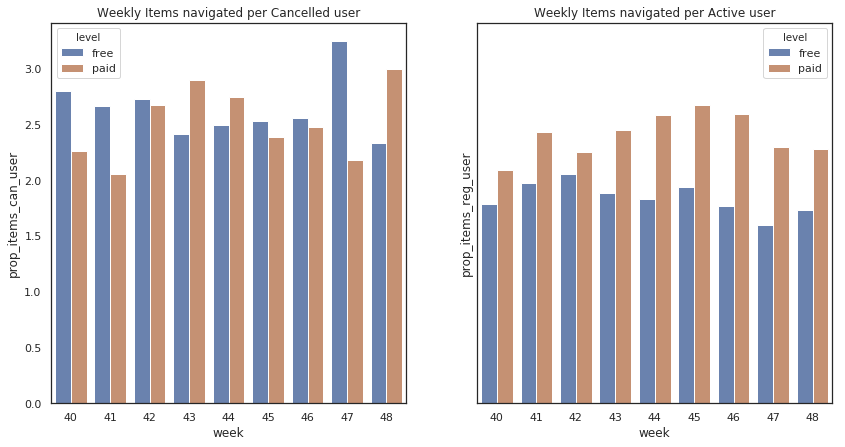

In [36]:
# Plot the df_items figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_items, x='week', y='prop_items_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly Items navigated per Cancelled user")

ax2 = sbn.barplot(data=df_items, x='week', y='prop_items_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly Items navigated per Active user")

plt.show();

The number of `items navigated per weeks` trend is clear for `free and paid active` users. But trean can not be clearly seen for `cancelled` users. Now let us consider number of `Thumbu up, Thumbs down, Add friend` events  

In [37]:
# SQL to get the count of thumbs up per cancelled user by week
df_thumbs_up_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'Thumbs Up'
   and b.page = 'Cancel'
 group by 
       week
      ,a.level
 order by 
       week
      ,a.level
''').toPandas()

In [38]:
# SQL to get the count of thumbs down per cancelled user by week
df_thumbs_down_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'Thumbs Down'
   and b.page = 'Cancel'
 group by 
       week
      ,a.level
 order by 
       week
      ,a.level
''').toPandas()

In [39]:
# SQL to get the count of add friend event per cancelled user by week
df_add_friend_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'Add Friend'
   and b.page = 'Cancel'
 group by 
       week
      ,a.level
 order by 
       week
      ,a.level
''').toPandas()

In [40]:
# SQL to get the count of thumbs up event per active user by week

df_thumbs_up_r = spark.sql('''
-- active users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  from log_table a
 where a.page = 'Thumbs Up'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
         ,a.level
         ,a.page
order by week
         ,a.level
         ,a.page
''').toPandas()

In [41]:
# SQL to get the count of thumbs down event per active user by week

df_thumbs_down_r = spark.sql('''
-- active users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  from log_table a
 where a.page = 'Thumbs Down'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
         ,a.level
         ,a.page
order by week
         ,a.level
         ,a.page
''').toPandas()

In [42]:
# SQL to get the count of add friend event per active user by week

df_add_friend_r = spark.sql('''
-- active users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  from log_table a
 where a.page = 'Add Friend'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
         ,a.level
         ,a.page
order by week
         ,a.level
         ,a.page
''').toPandas()

In [43]:
# Calcuate per user events cancelled user
df_thumbs_up_c['event_per_user'] = df_thumbs_up_c['Can_user_event'] / df_thumbs_up_c['user_C'] 
df_thumbs_down_c['event_per_user'] = df_thumbs_down_c['Can_user_event'] / df_thumbs_down_c['user_C']
df_add_friend_c['event_per_user'] = df_add_friend_c['Can_user_event'] / df_add_friend_c['user_C'] 

# Calcuate per user events active user
df_thumbs_up_r['event_per_user'] = df_thumbs_up_r['active_user_event'] / df_thumbs_up_r['user_R'] 
df_thumbs_down_r['event_per_user'] = df_thumbs_down_r['active_user_event'] / df_thumbs_down_r['user_R']
df_add_friend_r['event_per_user'] = df_add_friend_r['active_user_event'] / df_add_friend_r['user_R'] 

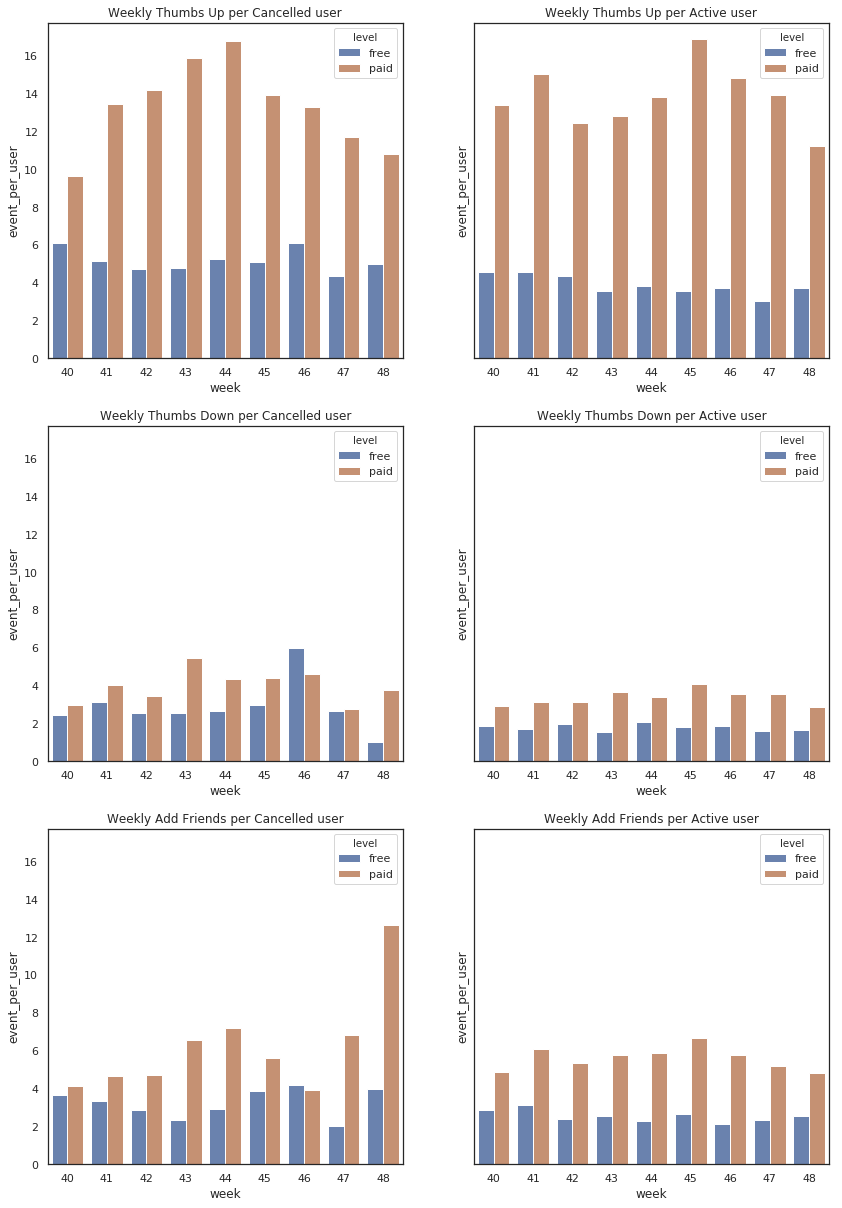

In [44]:
# Plot the events figures as graph
f, axes = plt.subplots(3, 2, figsize=(14, 21), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)


list_dfs = [[df_thumbs_up_c, df_thumbs_up_r],
            [df_thumbs_down_c, df_thumbs_down_r],
            [df_add_friend_c, df_add_friend_r],
           ]

titles = [["Weekly Thumbs Up per Cancelled user", "Weekly Thumbs Up per Active user" ],
          ["Weekly Thumbs Down per Cancelled user", "Weekly Thumbs Down per Active user" ],
          ["Weekly Add Friends per Cancelled user", "Weekly Add Friends per Active user" ],
         ]

for i,a in enumerate(axes):
    for j,ax in enumerate(a):
        ax = sbn.barplot(data=list_dfs[i][j], x='week', y='event_per_user', hue='level', ax=axes[i,j], saturation=0.50); 
        ax.set_title(titles[i][j]);

plt.show();

The above graphs shows `Cancelled` users and `Active` user are having faily same level of thumbs up and thumbs downs. `Cancel` users have relatively add more friends than `active` users. This could be they have more enagaged with friends :)

Let us check the `roll advert` freequency for Active and cancelled users

In [45]:
# SQL to get the count of roll advert per cancelled user by week
df_roll_advert_c = spark.sql('''
-- cancelled user
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  from log_table a
      ,log_table b
 where a.userId = b.userId
   and a.page = 'Roll Advert'
   and b.page = 'Cancel'
 group by 
       week
      ,a.level
 order by 
       week
      ,a.level
''').toPandas()

In [46]:
df_roll_advert_c.head()

,week,level,Can_user_event,user_C
0,40,free,679,61
1,40,paid,22,14
2,41,free,459,46
3,41,paid,15,6
4,42,free,346,37


In [47]:
# SQL to get the count of advert event per active user by week

df_roll_advert_r = spark.sql('''
-- active users 
select weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  from log_table a
 where a.page = 'Roll Advert'
   and a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 group by week
         ,a.level
         ,a.page
order by week
         ,a.level
         ,a.page
''').toPandas()

In [48]:
df_roll_advert_r.head()

,week,level,page,active_user_event,user_R
0,40,free,Roll Advert,924,151
1,40,paid,Roll Advert,18,18
2,41,free,Roll Advert,876,134
3,41,paid,Roll Advert,25,20
4,42,free,Roll Advert,690,114


In [49]:
# Calcuate per user events 
df_roll_advert_c['event_per_user'] = df_roll_advert_c['Can_user_event'] / df_roll_advert_c['user_C'] 
df_roll_advert_r['event_per_user'] = df_roll_advert_r['active_user_event'] / df_roll_advert_r['user_R'] 

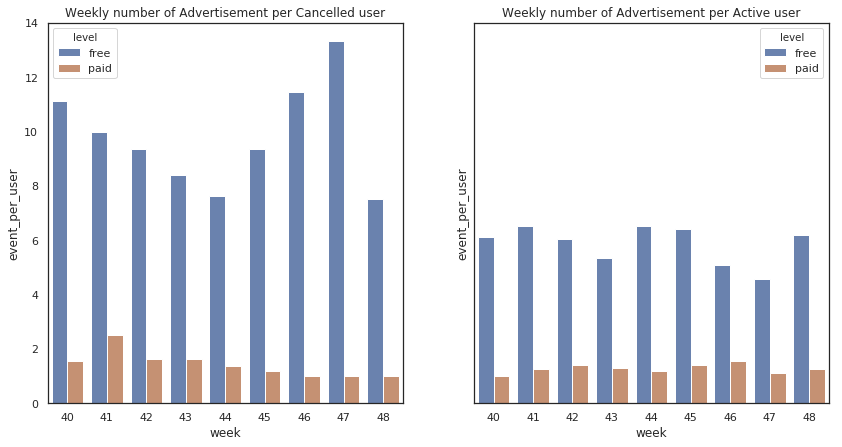

In [50]:
# Plot the roll advert data as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_roll_advert_c, x='week', y='event_per_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly number of Advertisement per Cancelled user")

ax2 = sbn.barplot(data=df_roll_advert_r, x='week', y='event_per_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly number of Advertisement per Active user")

plt.show();

Looks like the `cancelled` users have got more adverts that `active` users.  THis is possible because of more time they have spent and overall more songs they have listen the remaining `active` users.
Let us now consider how the `song` are impacts `Cancel`, `Downgrade` and `Upgrade`.  

In [51]:
df_song_c = spark.sql( '''
select a.song, count(distinct(a.userId)) as can_user
  from log_table a
      ,log_table b
where a.userId = b.userId
  and a.page = 'NextSong'
  and b.page = 'Cancel'
group by a.song
order by 2 desc
limit 50
''').toPandas()

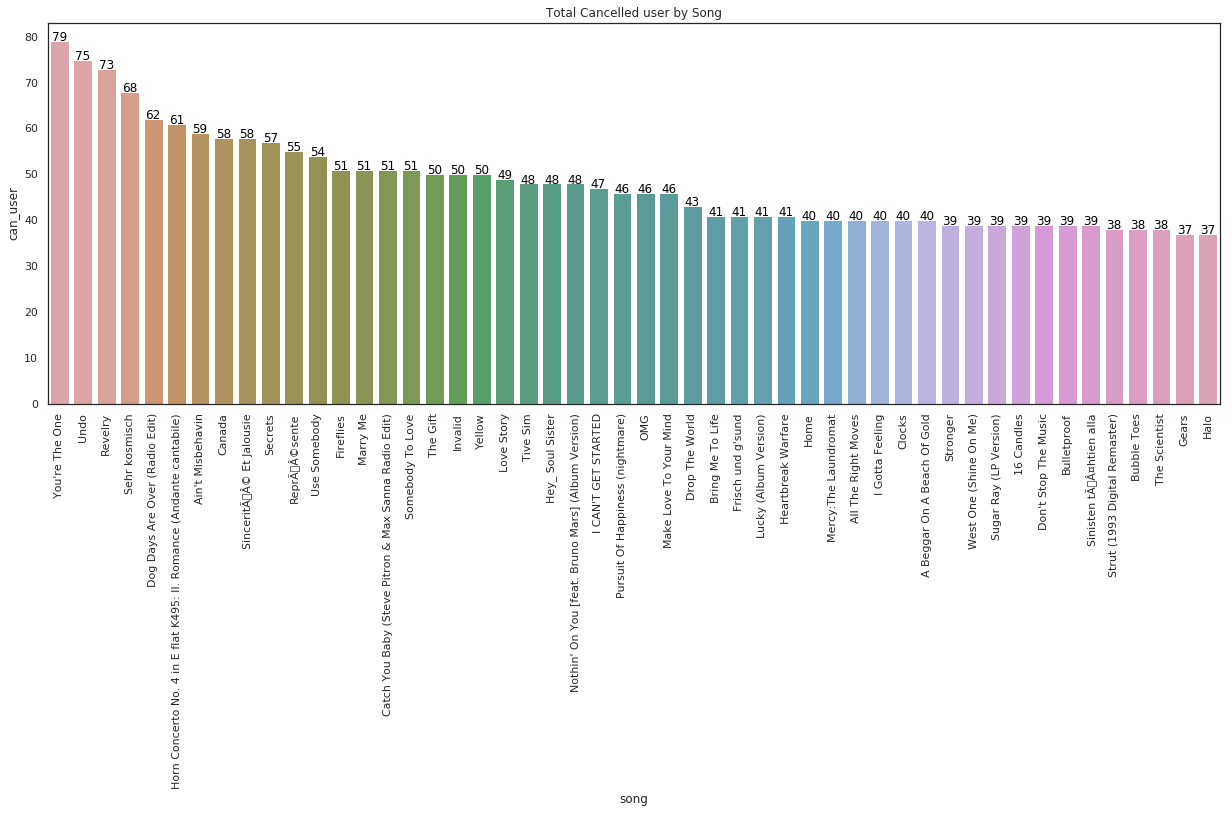

In [52]:
# Plot the df_song_c figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_c, x='song', y='can_user', saturation=0.50);
ax1.set_title("Total Cancelled user by Song")

for i, row in df_song_c.iterrows():
   ax1.text(row.name, row.can_user, row.can_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

In [53]:
# Find the song where most User downgraded
df_song_d = spark.sql( '''
select a.song, count(distinct(a.userId)) as downgrade_user
  from log_table a
      ,log_table b
where a.userId = b.userId
  and a.page = 'NextSong'
  and b.page = 'Downgrade'
group by a.song
order by 2 desc
limit 50
''').toPandas()

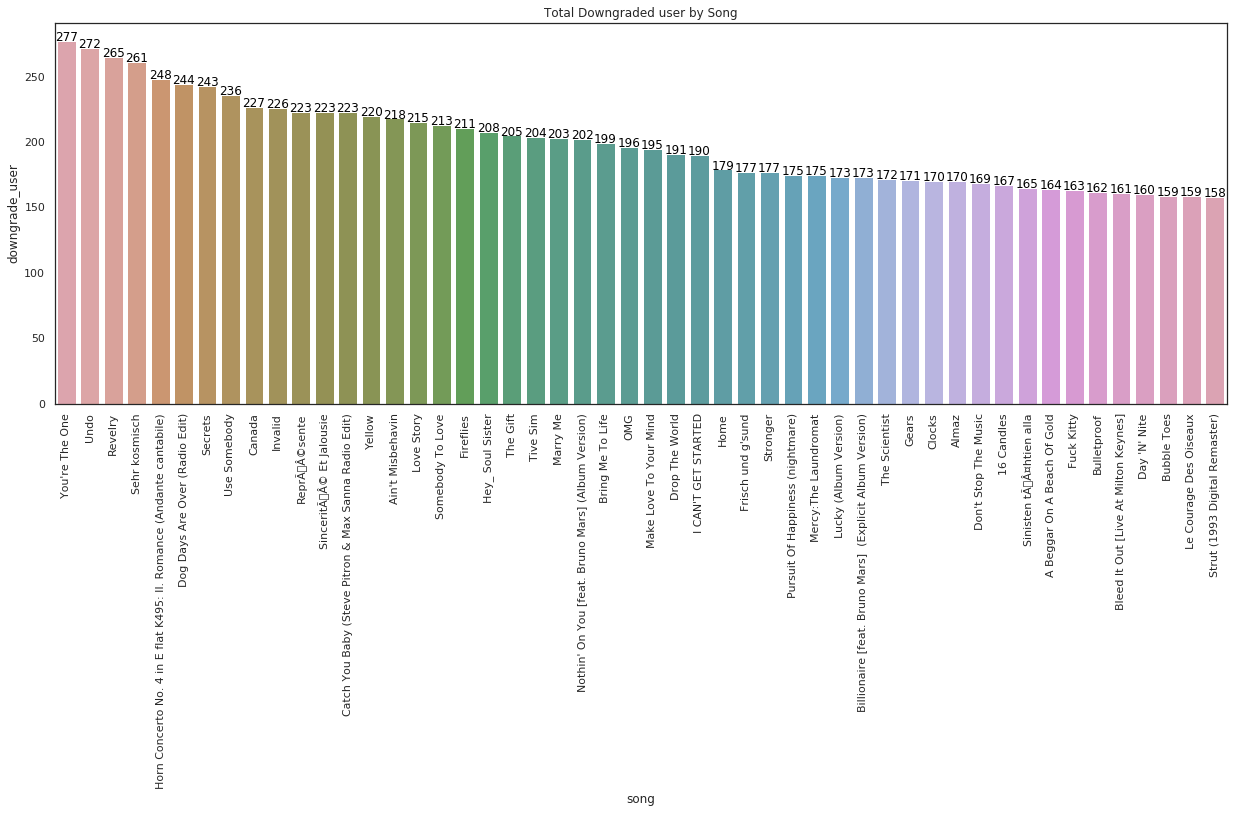

In [54]:
# Plot the df_song_c figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_d, x='song', y='downgrade_user', saturation=0.50);
ax1.set_title("Total Downgraded user by Song")

for i, row in df_song_d.iterrows():
   ax1.text(row.name, row.downgrade_user, row.downgrade_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

In [55]:
df_song_u = spark.sql( '''
select a.song, count(distinct(a.userId)) as upgrade_user
  from log_table a
      ,log_table b
where a.userId = b.userId
  and a.page = 'NextSong'
  and b.page = 'Upgrade'
group by a.song
order by 2 desc
limit 50
''').toPandas()

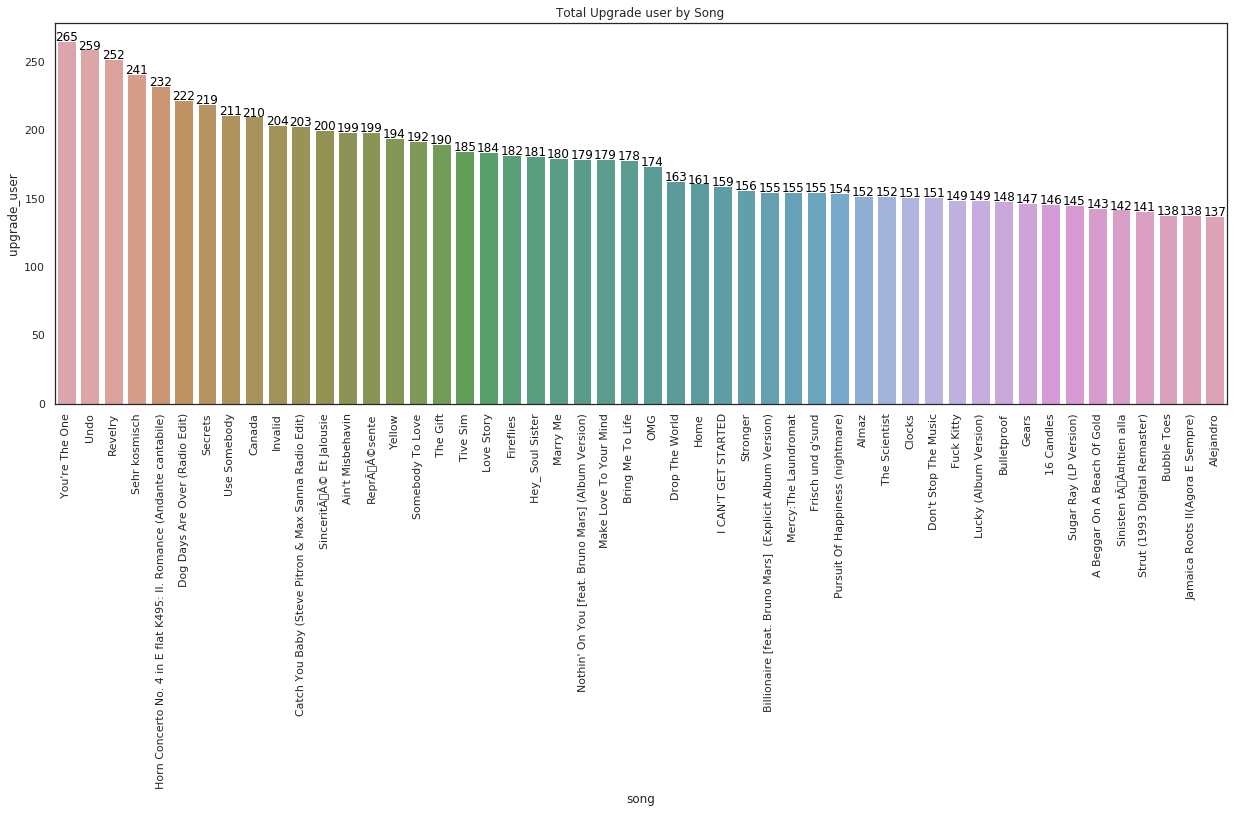

In [56]:
# Plot the df_song_c figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_u, x='song', y='upgrade_user', saturation=0.50);
ax1.set_title("Total Upgrade user by Song")

for i, row in df_song_u.iterrows():
   ax1.text(row.name, row.upgrade_user, row.upgrade_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

We coud observe that first 4 song are same in all the 3 categories `Cancel`, `Upgrade` and `downgrade`.  That is possible due to they could be most popular song for all users.  Never the less different user have have listenend to diffent set of songs so we will have unique score for all the songes listen by the user.

We could generally observe that cancelled users were more engaged with Sparkify , listing to more song, spending more time, more navigation, thumbs up, thumbs down, add friend etc, than the active user. Possibly the cancelled user have explored the Sparkify more that the existing active users. Hence they could have cancelled as there is not much to explore further.

In [57]:
%%sparksql  -l 999

select distinct(page)from log_table

page
Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

We are considering a time series dataset. So we have to make full use of how data - in this case representing user behaviour changed over time. Based of the Data Exploration Analysis done so far can thing about these feature `per user per day`

> * Daily listening time in minitues   - representing Time spent in listening to songs 
> * number of sessions daily - How often user logoff and logged in every day
> * number of items in session daily  - How much user was navigating daily
> * number of songs daily  - Number of song user listen daily,  this is different for how long because use could just play few minutes of the song and skip to nextsong
> * number of thumbs up daily
> * numer of thumbs downs daily
> * number of upgrades daily
> * number of roll adverts daily
> * number of downgrades daily
> * number of add friends daily
> * number of add to playlist daily
> * number of distinct artist daily
> * number of distinct songs daily
> * sum cancelled user for all the song listened for the day - total number of user cancelled on that day and also were listenting to that song, this will be zero before a user cancelled and will remain the from the day user has cancelled
> * sum downgrade user of all the song listened the day - total number of user downgradred on that day and also were listenting to that song, this will be zero before a user downgraded and continue to increase if there are more downgrade by same user
sum upgrade user of all the song listened the day 
> * length of time between upgrade and cancellation - This will be 0 for user who has not cancelled 
> * lenght of time between downgrades - this will be 0 for user who are free or user how have not downgraded.  This will be different for different downgrade period for same user
> * lenght of time between last downgrade and cancellation - this will be 0 if not downgraded and cancelled, this will be actual lenght of time between downgrade and cancel in days.

At the end of the feature engineering we will have 1 feature vector `per user per day` of data in the dataset and label users as `1` if `active` and `0` if `Cancel`led

In [ ]:
df.head()

In [ ]:
%%sparksql -l 100
select distinct(userId)
from log_table
where page = 'Cancel'

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.